In [2]:
import lightgbm as lgb
import numpy as np
import os
from datetime import datetime
import shap
from sklearn import datasets as ds
import ndcg
import data_format_read
import pandas as pd
import scipy
import collections

D:\Anaconda\envs\deep_learning\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\envs\deep_learning\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\envs\deep_learning\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\envs\deep_learning\lib\site-packages\tensorflow\python\framework\dtypes.py:5

In [3]:
# 数据地址
base_path = os.path.abspath(os.path.join(os.getcwd(), "../"))
train_path = base_path + '\\data\\train\\'
cv_path = base_path + '\\data\\crossV\\'

raw_data_path = train_path + 'raw_train.txt'
data_feats = train_path + 'feat.txt'
data_group = train_path + 'group.txt'

model_path = base_path + '\\data\\model\\model.mod'
save_plot_path = base_path + '\\data\\plot\\tree_plot'

In [4]:
def load_data(feats, group):
    '''
    加载数据
    分别加载feature,label,query
    :param feats:
    :param group:
    :return:
    '''

    x_train, y_train = ds.load_svmlight_file(feats)
    q_train = np.loadtxt(group)

    return x_train, y_train, q_train

In [5]:
def train(x_train, y_train, q_train, model_save_path=None):
    '''
    模型的训练和保存
    :param x_train:
    :param y_train:
    :param q_train:
    :param model_save_path:
    :return:
    '''

    train_data = lgb.Dataset(x_train, label=y_train, group=q_train)
    params = {
        'task': 'train',  # 执行的任务类型
        'boosting_type': 'gbdt',  # 基学习器
        'objective': 'lambdarank',  # 排序任务(目标函数)
        'metric': 'ndcg',  # 度量的指标(评估函数)
#         'max_position': 10,  # @NDCG 位置优化
        'metric_freq': 50,  # 每隔多少次输出一次度量结果
        'train_metric': True,  # 训练时就输出度量结果
        'ndcg_at': [10],
        'max_bin': 255,  # 一个整数，表示最大的桶的数量。默认值为 255。lightgbm 会根据它来自动压缩内存。如max_bin=255 时，则lightgbm 将使用uint8 来表示特征的每一个值。
        'num_iterations': 600,  # 迭代次数，即生成的树的棵数
        'learning_rate': 0.005,  # 学习率
        'num_leaves': 31,  # 叶子数
        # 'max_depth':6,
        'tree_learner': 'serial',  # 用于并行学习，‘serial’： 单台机器的tree learner
        'min_data_in_leaf': 30,  # 一个叶子节点上包含的最少样本数量
        'verbose': 2  # 显示训练时的信息
    }
    gbm = lgb.train(params, train_data, valid_sets=[train_data])
    if(model_save_path is not None):
        gbm.save_model(model_save_path)
    return gbm

In [7]:
# train
train_start = datetime.now()
x_train, y_train, q_train = load_data(data_feats, data_group)
gbm = train(x_train, y_train, q_train, model_path)
train_end = datetime.now()
consume_time = (train_end - train_start).seconds
print("consume time : {}".format(consume_time))

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.237551
[LightGBM] [Debug] init for col-wise cost 0.000009 seconds, init for row-wise cost 0.005198 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1975
[LightGBM] [Info] Number of data points in the train set: 20926, number of used features: 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 8
[1]	training's ndcg@10: 0.361964
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[2]	training's ndcg@10: 0.317294
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[3]	training's ndcg@10: 0.326949
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 14
[4]	training's ndcg@10: 0.356958
[LightGBM] [

[93]	training's ndcg@10: 0.528956
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[94]	training's ndcg@10: 0.529548
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[95]	training's ndcg@10: 0.529713
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 15
[96]	training's ndcg@10: 0.531527
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[97]	training's ndcg@10: 0.53129
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[98]	training's ndcg@10: 0.531897
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 15
[99]	training's ndcg@10: 0.531948
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 15
[100]	training's ndcg@10: 0.532161
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[101]	training's ndcg@10: 0.531723
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[102]	training's ndcg@10: 0.530186
[LightGBM] [Debug] Trained a

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[187]	training's ndcg@10: 0.568535
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[188]	training's ndcg@10: 0.568669
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[189]	training's ndcg@10: 0.56877
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[190]	training's ndcg@10: 0.568792
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[191]	training's ndcg@10: 0.568792
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[192]	training's ndcg@10: 0.570769
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[193]	training's ndcg@10: 0.572485
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[194]	training's ndcg@10: 0.572529
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[195]	training's ndcg@10: 0.577115
[LightGBM] [Debug] Trained a tree with leaves = 31 and m

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[274]	training's ndcg@10: 0.592018
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[275]	training's ndcg@10: 0.591966
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[276]	training's ndcg@10: 0.592017
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[277]	training's ndcg@10: 0.591987
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[278]	training's ndcg@10: 0.59199
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[279]	training's ndcg@10: 0.592037
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[280]	training's ndcg@10: 0.593242
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 8
[281]	training's ndcg@10: 0.593572
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 9
[282]	training's ndcg@10: 0.593545
[LightGBM] [Debug] Trained a tree with leaves = 31 and max

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 14
[353]	training's ndcg@10: 0.602821
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[354]	training's ndcg@10: 0.603394
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[355]	training's ndcg@10: 0.603083
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[356]	training's ndcg@10: 0.603643
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[357]	training's ndcg@10: 0.603674
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[358]	training's ndcg@10: 0.603269
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 14
[359]	training's ndcg@10: 0.603801
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[360]	training's ndcg@10: 0.603663
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[361]	training's ndcg@10: 0.603663
[LightGBM] [Debug] Trained a tree with leaves = 31 and 

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[448]	training's ndcg@10: 0.626623
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[449]	training's ndcg@10: 0.626623
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[450]	training's ndcg@10: 0.62538
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[451]	training's ndcg@10: 0.627767
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 15
[452]	training's ndcg@10: 0.627767
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[453]	training's ndcg@10: 0.627815
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[454]	training's ndcg@10: 0.627815
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[455]	training's ndcg@10: 0.627815
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[456]	training's ndcg@10: 0.627815
[LightGBM] [Debug] Trained a tree with leaves = 31 and m

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[533]	training's ndcg@10: 0.657361
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[534]	training's ndcg@10: 0.658604
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[535]	training's ndcg@10: 0.658697
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[536]	training's ndcg@10: 0.661107
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[537]	training's ndcg@10: 0.661107
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[538]	training's ndcg@10: 0.661023
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 9
[539]	training's ndcg@10: 0.661023
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[540]	training's ndcg@10: 0.661023
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[541]	training's ndcg@10: 0.661075
[LightGBM] [Debug] Trained a tree with leaves = 31 and m

In [36]:
test_predict = gbm.predict(x_train)
# test_qids = comments["inf_name"].drop(labels=range(vali_head,vali_tail))





In [8]:
feats_col_name = ["dtRatio"," direVar"," scene"," recp"," difRatio"," direRatio"," recVar ","refRatio"," buildRatio"]
#features
feature_mat = x_train.todense()
df_feature = pd.DataFrame(feature_mat)
#增加表头
df_feature.columns = feats_col_name
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(df_feature[feats_col_name])

In [6]:
# load JS visualization code to notebook
shap.initjs()

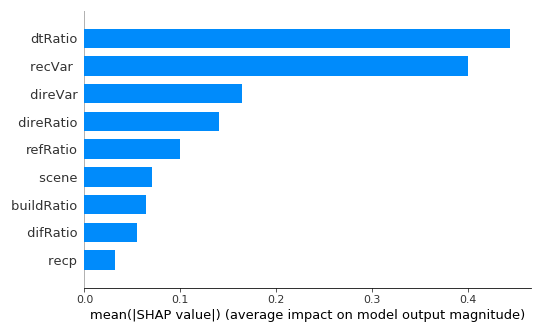

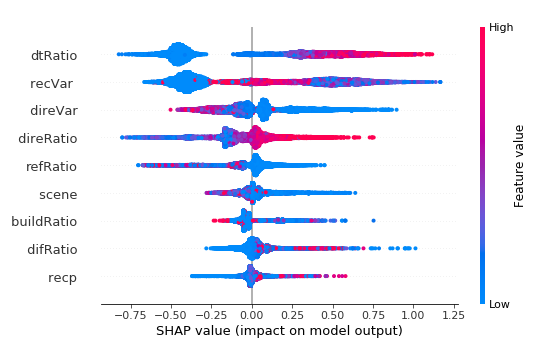

In [46]:
# plot_print_shap(explainer,shap_values,df_feature,2,partialFeat="dtRatio")
plot_print_shap(explainer,shap_values,df_feature,1)

In [16]:
shap.force_plot(explainer.expected_value, shap_values[397,:], df_feature.iloc[397,:])

In [15]:
shap.force_plot(explainer.expected_value, shap_values[327,:], df_feature.iloc[327,:])

In [36]:
shap.force_plot(explainer.expected_value, shap_values[339,:], df_feature.iloc[339,:])

In [18]:
shap.force_plot(explainer.expected_value, shap_values[0:1000,:], df_feature.iloc[0:1000,:])

In [25]:
def plot_print_shap(explainer,shap_values, df_feature, type,partialFeat=None,feat1=None,feat2=None):
    '''
    利用shap打印特征重要度
    :param model_path:
    :param data_feats:
    :param type:
    :return:
    '''
#     if not (os.path.exists(model_path) and os.path.exists(data_feats)):
#         print("file no exists! {}, {}".format(model_path, data_feats))
#         sys.exit(0)
#     gbm = lgb.Booster(model_file=model_path)
#     gbm.params["objective"] = "regression"
#     #feature列名
#     feats_col_name = []
#     for feat_index in range(46):
#         feats_col_name.append('feat' + str(feat_index) + 'name')
#     X_train, _ = ds.load_svmlight_file(data_feats)


    #特征总体分析，分别绘出散点图和条状图
    if type == 1:
        #把一个特征对目标变量影响程度的绝对值的均值作为这个特征的重要性(不同于feature_importance的计算方式)
        shap.summary_plot(shap_values, df_feature[feats_col_name], plot_type="bar")
        # 对特征总体分析
        shap.summary_plot(shap_values, df_feature[feats_col_name])
    #部分依赖图的功能，与传统的部分依赖图不同的是，这里纵坐标不是目标变量y的数值而是SHAP值
    if type == 2:
        shap.dependence_plot(partialFeat, shap_values, df_feature[feats_col_name], interaction_index=None, show=True)
    # 两个变量交互下变量对目标值的影响
    if type == 3:
        shap.dependence_plot(feat1, shap_values, df_feature[feats_col_name], interaction_index=feat2, show=True)
    #多个变量的交互进行分析
    if type == 4:
        shap_interaction_values = explainer.shap_interaction_values(df_feature[feats_col_name])
        shap.summary_plot(shap_interaction_values, df_feature[feats_col_name], max_display=4, show=True)
    # visualize the training set predictions
    if type == 5:
        print("hhhhhhh")
        shap.force_plot(explainer.expected_value, shap_values[100,:], df_feature.iloc[100,:])

In [1]:
def plot_print_feature_shap(model_path, data_feats, type,partialFeat=None,feat1=None,feat2=None):
    '''
    利用shap打印特征重要度
    :param model_path:
    :param data_feats:
    :param type:
    :return:
    '''
#     if not (os.path.exists(model_path) and os.path.exists(data_feats)):
#         print("file no exists! {}, {}".format(model_path, data_feats))
#         sys.exit(0)
#     gbm = lgb.Booster(model_file=model_path)
#     gbm.params["objective"] = "regression"
#     #feature列名
#     feats_col_name = []
#     for feat_index in range(46):
#         feats_col_name.append('feat' + str(feat_index) + 'name')
#     X_train, _ = ds.load_svmlight_file(data_feats)
    gbm = model_path
    X_train = data_feats
    feats_col_name = ["scene","buildRatio","dtRatio","recVar","direRatio","direVar","difRatio","refRatio","recp"]
    
    #features
    feature_mat = X_train.todense()
    df_feature = pd.DataFrame(feature_mat)
    #增加表头
    df_feature.columns = feats_col_name
    explainer = shap.TreeExplainer(gbm)
    shap_values = explainer.shap_values(df_feature[feats_col_name])

    #特征总体分析，分别绘出散点图和条状图
    if type == 1:
        #把一个特征对目标变量影响程度的绝对值的均值作为这个特征的重要性(不同于feature_importance的计算方式)
        shap.summary_plot(shap_values, df_feature[feats_col_name], plot_type="bar")
        # 对特征总体分析
        shap.summary_plot(shap_values, df_feature[feats_col_name])
    #部分依赖图的功能，与传统的部分依赖图不同的是，这里纵坐标不是目标变量y的数值而是SHAP值
    if type == 2:
        shap.dependence_plot(partialFeat, shap_values, df_feature[feats_col_name], interaction_index=None, show=True)
    # 两个变量交互下变量对目标值的影响
    if type == 3:
        shap.dependence_plot(feat1, shap_values, df_feature[feats_col_name], interaction_index=feat2, show=True)
    #多个变量的交互进行分析
    if type == 4:
        shap_interaction_values = explainer.shap_interaction_values(df_feature[feats_col_name])
        shap.summary_plot(shap_interaction_values, df_feature[feats_col_name], max_display=4, show=True)
    # visualize the training set predictions
    if type == 5:
        shap.force_plot(explainer.expected_value, shap_values[0,:], feature_mat.iloc[0,:])

In [ ]:
# 最终预测
def predict(x_test, grid_pos, model_input_path):
    '''
     预测得分并排序
    :param x_test:
    :param comments:
    :param model_input_path:
    :return:
    '''

    gbm = lgb.Booster(model_file=model_input_path)  # 加载model

    ypred = gbm.predict(x_test)

    predicted_sorted_indexes = np.argsort(ypred)[::-1]  # 返回从大到小的索引

    t_results = grid_pos[predicted_sorted_indexes]  # 返回对应的comments,从大到小的排序

    return t_results

In [ ]:
def plot_tree(model_path, tree_index, save_plot_path):
    '''
    对模型进行可视化
    :param model_path:
    :param tree_index:
    :param save_plot_path:
    :return:
    '''
    if not os.path.exists(model_path):
        print("file no exists! {}".format(model_path))
        sys.exit(0)
    gbm = lgb.Booster(model_file=model_path)
    graph = lgb.create_tree_digraph(gbm, tree_index=tree_index, name='tree' + str(tree_index))
    graph.render(filename=save_plot_path, view=True) #可视图保存到save_plot_path中

In [9]:
def plot_print_feature_importance(model_path):
    '''
    打印特征的重要度
    :param model_path:
    :return:
    '''
    #模型中的特征是Column_数字,这里打印重要度时可以映射到真实的特征名
    # feats_dict = {
    #     'Column_0': '特征0名称',
    #     'Column_1': '特征1名称',
    #     'Column_2': '特征2名称',
    #     'Column_3': '特征3名称',
    #     'Column_4': '特征4名称',
    #     'Column_5': '特征5名称',
    #     'Column_6': '特征6名称',
    #     'Column_7': '特征7名称',
    #     'Column_8': '特征8名称',
    #     'Column_9': '特征9名称',
    #     'Column_10': '特征10名称',
    # }
    feats_dict = {}
    for feat_index in range(46):
        col =  'Column_' + str(feat_index)
        feats_dict[col] = 'feat' + str(feat_index) + 'name'

    if not os.path.exists(model_path):
        print("file no exists! {}".format(model_path))
        sys.exit(0)

    gbm = lgb.Booster(model_file=model_path)

    # 打印和保存特征重要度
    importances = gbm.feature_importance(importance_type='split')
    feature_names = gbm.feature_name()

    sum = 0.
    for value in importances:
        sum += value

    for feature_name, importance in zip(feature_names, importances):
        if importance != 0:
            feat_id = int(feature_name.split('_')[1]) + 1
            print('{} : {} : {} : {}'.format(feat_id, feats_dict[feature_name], importance, importance / sum))


In [10]:
def crossValid(train_path,k):
    '''
    交叉验证
    :param train_path:训练数据目录
    :param k: top k的NDCG值
    :return:
    '''
    feats = pd.read_csv(train_path+"\\feat.txt",header=None,sep=' ')
    groups = pd.read_csv(train_path+"\\group.txt",header=None)
    comments = pd.read_csv(train_path+"\\vali.csv",sep=',')
    step = np.int(groups.size*0.1)
    average_gdcg = 0
    for vali_group_pos in range(0,groups.size-step,step):
        pre = groups[:vali_group_pos]
        # 验证集的groups
        vali = groups[vali_group_pos:vali_group_pos+step]
        # 验证集在feats和comments中的位置区间--左闭右开
        vali_head = pre.values.sum()
        vali_tail = vali_head+vali.values.sum()
        # 训练集写入文件
        feats.drop(labels=range(vali_head,vali_tail)).to_csv(cv_path+"feat.txt",index=False,header=None,sep=" ")
        groups.drop(labels=range(vali_group_pos,vali_group_pos+step)).to_csv(cv_path+"group.txt",index=False,header=None,sep="\n")

        # 加载验证集
        test_qids = comments["inf_name"][vali_head:vali_tail]
        test_X = feats.drop(0,axis=1)[vali_head:vali_tail]
        test_y = feats[0][vali_head:vali_tail]
        comment = comments[vali_head:vali_tail]

        # 开始训练
        x_train, y_train, q_train = load_data(data_feats, data_group)
        gbm = train(x_train, y_train, q_train)

        # 验证
        test_predict = gbm.predict(test_X)
        
#         predicted_sorted_indexes = np.argsort(ypred)[::-1]  # 返回从大到小的索引
#         t_results = grid_pos[predicted_sorted_indexes]  # 返回对应的comment,从大到小的排序
        
        gdcg, _ = validate(test_qids, test_y, test_predict, 10)
        average_gdcg+=gdcg
        print("current all qid average ndcg: ", gdcg)
        print("job {}/{} done!".format(vali_group_pos+2,groups.size))

    print("average ndcg:",average_gdcg)

In [11]:
def ideal_dcg_k(scores, k):
    """
    前k个理想状态下的dcg
        Returns the Ideal DCG value of the list of scores and truncates to k values.
        Parameters
        ----------
        scores : list
            Contains labels in a certain ranked order
        k : int
            In the amount of values you want to only look at for computing DCG

        Returns
        -------
        Ideal_DCG_val: int
            This is the value of the Ideal DCG on the given scores
    """
    # 相关度降序排序
    scores = [score for score in sorted(scores)[::-1]]
    return dcg_k(scores, k)

In [12]:
def dcg_k(scores, k):
    """
        Returns the DCG value of the list of scores and truncates to k values.
        Parameters
        ----------
        scores : list
            Contains labels in a certain ranked order
        k : int
            In the amount of values you want to only look at for computing DCG

        Returns
        -------
        DCG_val: int
            This is the value of the DCG on the given scores
    """
    return np.sum([
                      (np.power(2, scores[i]) - 1) / np.log2(i + 2)
                      for i in range(len(scores[:k]))
                      ])

In [13]:
def get_groups(qids):
    """Makes an iterator of query groups on the provided list of query ids.

    Parameters
    ----------
    qids : array_like of shape = [n_samples]
        List of query ids.

    Yields
    ------
    row : (qid, int, int)
        Tuple of query id, from, to.
        ``[i for i, q in enumerate(qids) if q == qid] == range(from, to)``

    """
    prev_qid = None
    prev_limit = 0
    total = 0

    for i, qid in enumerate(qids):
        total += 1
        if qid != prev_qid:
            if i != prev_limit:
                yield (prev_qid, prev_limit, i)
            prev_qid = qid
            prev_limit = i

    if prev_limit != total:
        yield (prev_qid, prev_limit, total)

In [14]:
def group_queries(training_data, qid_index):
    """
        Returns a dictionary that groups the documents by their query ids.
        Parameters
        ----------
        training_data : Numpy array of lists
            Contains a list of document information. Each document's format is [relevance score, query index, feature vector]
        qid_index : int
            This is the index where the qid is located in the training data

        Returns
        -------
        query_indexes : dictionary
            The keys were the different query ids and teh values were the indexes in the training data that are associated of those keys.
    """
    query_indexes = {}  # 每个qid对应的样本索引范围,比如qid=1020,那么此qid在training data中的训练样本从0到100的范围, { key=str,value=[] }
    index = 0
    for record in training_data:
        query_indexes.setdefault(record[qid_index], [])
        query_indexes[record[qid_index]].append(index)
        index += 1
    return query_indexes

In [23]:
grid_l = 30 # 候选栅格长度

def validate(qids, targets, preds, comment, k):
    """
    Predicts the scores for the test dataset and calculates the NDCG value.
    Parameters
    ----------
    data : Numpy array of documents
        Numpy array of documents with each document's format is [relevance score, query index, feature vector]
    k : int
        this is used to compute the NDCG@k

    Returns
    -------
    average_ndcg : 所有数据的平均价ndcg值
        
    every_qid_ndcg : 每一组数据的ndcg值
        
    prec ：前top k的栅格包含干扰源的准确率
    
    k_dis:前top k 中离干扰源的最近距离的列表集合
    
    dis:排名第一的栅格离干扰源的最近距离列表集合
    
    average_k_dis:所有组的平均top k离干扰源最近距离
    
    average_dis:所有组的平均top 1离干扰源最近距离
    """
    query_groups = get_groups(qids)  # (qid,from,to),一个元组,表示这个qid的样本从哪到哪
    all_ndcg = []
    every_qid_ndcg = collections.OrderedDict()
    
    cnt = 0 # 当前top k的栅格包含干扰源的计数变量
    gps = 0 # 预测数据的总组数
    k_dis = [] # 前top k 中离干扰源的最近距离的集合
    dis = [] # 排名第一的栅格离干扰源的最近距离集合

    for qid, a, b in query_groups:
        predicted_sorted_indexes = np.argsort(preds[a:b])[::-1] # 从大到小的索引
        t_results = targets[a:b] # 目标数据的相关度
        t_results = t_results[predicted_sorted_indexes] #是predicted_sorted_indexes排好序的在test_data中的相关度

        print(t_results)
        
        gps+=1
        if t_results.max() in t_results[:k]:
            cnt+=1
        
        # 距离干扰源的3维距离
        k_dis.append(np.sqrt(comment[a:b].iloc[predicted_sorted_indexes[:k]['dis'].min()*grid_l]))
        dis.append(np.sqrt(comment[a:b].iloc[predicted_sorted_indexes[:1]['dis'].min()*grid_l]))                      
                                 
        dcg_val = dcg_k(t_results, k)
        idcg_val = ideal_dcg_k(t_results, k)
        ndcg_val = (dcg_val / idcg_val)
        all_ndcg.append(ndcg_val)
        every_qid_ndcg.setdefault(qid, ndcg_val)

    average_ndcg = np.nanmean(all_ndcg)
    prec = cnt / gps
    average_k_dis =  np.sqrt(k_dis.sum()/len(k_dis))
    average_dis = dis.sum()/len(dis)      

    return average_ndcg, every_qid_ndcg ,prec, k_dis, dis, average_k_dis,average_dis


    '''
    for query in query_indexes:
        results = np.zeros(len(query_indexes[query]))

        for tree in self.trees:
            results += self.learning_rate * tree.predict(data[query_indexes[query], 2:])
        predicted_sorted_indexes = np.argsort(results)[::-1]
        t_results = data[query_indexes[query], 0] # 第0列的相关度
        t_results = t_results[predicted_sorted_indexes]

        dcg_val = dcg_k(t_results, k)
        idcg_val = ideal_dcg_k(t_results, k)
        ndcg_val = (dcg_val / idcg_val)
        average_ndcg.append(ndcg_val)
    average_ndcg = np.nanmean(average_ndcg)
    return average_ndcg
    '''

In [17]:
feats = pd.read_csv(train_path+"\\feat.txt",header=None,sep=' ')
groups = pd.read_csv(train_path+"\\group.txt",header=None)
comments = pd.read_csv(train_path+"\\vali.csv",sep=',')
step = np.int(groups.size*0.1)
average_gdcg = 0


2

In [109]:
for vali_group_pos in range(0,groups.size-step,step):
    pre = groups[:vali_group_pos]
    # 验证集的groups
    vali = groups[vali_group_pos:vali_group_pos+step]
    # 验证集在feats和comments中的位置区间--左闭右开
    vali_head = pre.values.sum()
    vali_tail = vali_head+vali.values.sum()
    # 训练集写入文件
    cv_feat = cv_path+"feat.txt"
    cv_group = cv_path+"group.txt"
    feats.drop(labels=range(vali_head,vali_tail)).to_csv(cv_feat,index=False,header=None,sep=" ")
    groups.drop(labels=range(vali_group_pos,vali_group_pos+step)).to_csv(cv_group,index=False,header=None,sep="\n")
    
    # 验证集写入文件，并加载
    test_feat = cv_path+"test_feat.txt"
    feats[vali_head:vali_tail].to_csv(test_feat,index=False,header=None,sep=" ")
    test_X, test_y = ds.load_svmlight_file(test_feat)
    
    test_qids = comments["inf_name"][vali_head:vali_tail]
    comment = comments[vali_head:vali_tail]
    
    # 开始训练
    x_train, y_train, q_train = load_data(cv_feat, cv_group)
    gbm = train(x_train, y_train, q_train)

    # 验证
    test_predict = gbm.predict(test_X)

#         predicted_sorted_indexes = np.argsort(ypred)[::-1]  # 返回从大到小的索引
#         t_results = grid_pos[predicted_sorted_indexes]  # 返回对应的comments,从大到小的排序
    
    
    gdcg, _,prec = validate(test_qids, test_y, test_predict, 10)
    average_gdcg+=gdcg
    print("current all qid average ndcg: ", gdcg)
    print("current all qid precision: ", prec)
    print("job {}/{} done!".format(vali_group_pos+2,groups.size))

    break

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.235762
[LightGBM] [Debug] init for col-wise cost 0.000004 seconds, init for row-wise cost 0.001793 seconds
[LightGBM] [Debug] col-wise cost 0.000297 seconds, row-wise cost 0.000122 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1975
[LightGBM] [Info] Number of data points in the train set: 20064, number of used features: 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 8
[1]	training's ndcg@10: 0.457031
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[2]	training's ndcg@10: 0.331329
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 9
[76]	training's ndcg@10: 0.569893
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 8
[77]	training's ndcg@10: 0.575835
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 9
[78]	training's ndcg@10: 0.577244
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 9
[79]	training's ndcg@10: 0.579301
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 9
[80]	training's ndcg@10: 0.581402
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[81]	training's ndcg@10: 0.584915
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 9
[82]	training's ndcg@10: 0.58946
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 8
[83]	training's ndcg@10: 0.590193
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[84]	training's ndcg@10: 0.59105
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 8
[85]

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[156]	training's ndcg@10: 0.655482
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[157]	training's ndcg@10: 0.654152
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[158]	training's ndcg@10: 0.65478
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 9
[159]	training's ndcg@10: 0.654425
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[160]	training's ndcg@10: 0.654456
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 8
[161]	training's ndcg@10: 0.657262
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 8
[162]	training's ndcg@10: 0.657577
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 9
[163]	training's ndcg@10: 0.657829
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 9
[164]	training's ndcg@10: 0.656166
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_de

[235]	training's ndcg@10: 0.688562
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[236]	training's ndcg@10: 0.688208
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[237]	training's ndcg@10: 0.688208
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[238]	training's ndcg@10: 0.688297
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[239]	training's ndcg@10: 0.690955
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[240]	training's ndcg@10: 0.689621
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[241]	training's ndcg@10: 0.691448
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 8
[242]	training's ndcg@10: 0.691431
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[243]	training's ndcg@10: 0.691407
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[244]	training's ndcg@10: 0.69295
[LightGBM] [Debug] Tra

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[319]	training's ndcg@10: 0.727354
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[320]	training's ndcg@10: 0.727339
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[321]	training's ndcg@10: 0.72723
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 9
[322]	training's ndcg@10: 0.727339
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[323]	training's ndcg@10: 0.727389
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 9
[324]	training's ndcg@10: 0.725991
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[325]	training's ndcg@10: 0.725707
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[326]	training's ndcg@10: 0.724332
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[327]	training's ndcg@10: 0.724332
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[403]	training's ndcg@10: 0.744612
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[404]	training's ndcg@10: 0.745754
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[405]	training's ndcg@10: 0.745754
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[406]	training's ndcg@10: 0.748417
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 16
[407]	training's ndcg@10: 0.748417
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[408]	training's ndcg@10: 0.748474
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[409]	training's ndcg@10: 0.748838
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 16
[410]	training's ndcg@10: 0.748983
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 9
[411]	training's ndcg@10: 0.75054
[LightGBM] [Debug] Trained a tree with leaves = 31 and ma

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[486]	training's ndcg@10: 0.769122
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 18
[487]	training's ndcg@10: 0.769251
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[488]	training's ndcg@10: 0.769523
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[489]	training's ndcg@10: 0.769069
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 15
[490]	training's ndcg@10: 0.769519
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[491]	training's ndcg@10: 0.770893
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[492]	training's ndcg@10: 0.770699
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[493]	training's ndcg@10: 0.770427
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[494]	training's ndcg@10: 0.770699
[LightGBM] [Debug] Trained a tree with leaves = 31 and 

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[569]	training's ndcg@10: 0.786458
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[570]	training's ndcg@10: 0.786433
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[571]	training's ndcg@10: 0.786745
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[572]	training's ndcg@10: 0.786735
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[573]	training's ndcg@10: 0.787422
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[574]	training's ndcg@10: 0.78777
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[575]	training's ndcg@10: 0.787879
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[576]	training's ndcg@10: 0.787879
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[577]	training's ndcg@10: 0.787879
[LightGBM] [Debug] Trained a tree with leaves = 31 and m

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[652]	training's ndcg@10: 0.811507
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[653]	training's ndcg@10: 0.812882
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[654]	training's ndcg@10: 0.812813
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[655]	training's ndcg@10: 0.812941
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[656]	training's ndcg@10: 0.812941
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 16
[657]	training's ndcg@10: 0.813147
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 14
[658]	training's ndcg@10: 0.813147
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[659]	training's ndcg@10: 0.813147
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[660]	training's ndcg@10: 0.813232
[LightGBM] [Debug] Trained a tree with leaves = 31 and 

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[736]	training's ndcg@10: 0.833161
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[737]	training's ndcg@10: 0.833161
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[738]	training's ndcg@10: 0.833161
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[739]	training's ndcg@10: 0.833161
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[740]	training's ndcg@10: 0.833161
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[741]	training's ndcg@10: 0.833246
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 9
[742]	training's ndcg@10: 0.833572
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[743]	training's ndcg@10: 0.833572
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 9
[744]	training's ndcg@10: 0.833572
[LightGBM] [Debug] Trained a tree with leaves = 31 and ma

ValueError: not enough values to unpack (expected 3, got 2)

In [61]:
predicted_sorted_indexes = np.argsort(test_predict)[::-1]  # 返回从大到小的索引
t_results = grid_pos[predicted_sorted_indexes]  # 返回对应的comments,从大到小的排序

array([ 1.00564731e-01,  6.09879250e-01,  1.29728359e-01,  5.23220475e-01,
        1.41061431e-01,  2.64327472e-01,  1.45271870e-01,  1.08946969e+00,
        3.76619263e-01,  5.06752691e-01,  1.14221593e-01, -1.00002939e+00,
        1.71309196e-01,  9.78167793e-01,  2.74238960e-01,  6.07922433e-01,
        2.90121155e-01,  4.87040392e-01, -1.01783470e-01, -3.89849023e-01,
       -7.37422888e-01, -7.59664555e-01,  9.88745884e-01,  1.08362884e+00,
       -4.08365651e-01, -8.27432095e-01, -1.01787823e-01, -2.43322801e-01,
        4.94439013e-01,  4.11107034e-01,  8.46448988e-01,  1.05417117e-02,
        7.48281431e-01, -7.72840923e-01, -1.05382123e+00, -1.72651498e-01,
       -7.14057280e-01,  9.64296209e-01,  1.19797797e+00, -4.20326250e-01,
       -4.03834112e-01, -1.85282905e-02, -6.32338030e-01, -8.22636862e-01,
       -5.04843185e-01, -4.89384387e-01,  1.19080149e+00,  7.39835412e-01,
       -5.29361534e-01, -6.59901613e-01, -7.82818518e-01, -1.07666142e+00,
        2.48335714e-01, -

In [149]:
query_groups = get_groups(test_qids)  # (qid,from,to),一个元组,表示这个qid的样本从哪到哪
all_ndcg = []
every_qid_ndcg = collections.OrderedDict()

for qid, a, b in query_groups:
    predicted_sorted_indexes = np.argsort(test_predict[a:b])[::-1] # 从大到小的索引
    t_results = test_y[a:b] # 目标数据的相关度
    t_results = t_results[predicted_sorted_indexes] #是predicted_sorted_indexes排好序的在test_data中的相关度
    print("\n")
    print(t_results.size)
    print(t_results)
    
    comments[a:b].iloc[predicted_sorted_indexes]

#         dcg_val = dcg_k(t_results, k)
#         idcg_val = ideal_dcg_k(t_results, k)
#         ndcg_val = (dcg_val / idcg_val)
#         all_ndcg.append(ndcg_val)
#         every_qid_ndcg.setdefault(qid, ndcg_val)



1147
[9. 7. 8. ... 0. 0. 0.]


998
[ 9.  9.  9.  9.  8. 10.  9.  9.  8.  7.  9.  9.  8.  8.  8.  8.  8.  9.
  4.  8.  9.  9.  8.  9.  9.  8.  7.  8.  8.  6.  9.  9.  8.  7.  9.  8.
  8.  8.  8.  8.  8.  9.  8.  7.  7.  7.  7.  7.  5.  7.  7.  7.  5.  9.
  8.  7.  6.  5.  7.  8.  6.  4.  6.  8.  8.  7.  5.  6.  7.  7.  5.  7.
  9.  8.  7.  6.  9.  0.  7.  5.  6.  8.  8.  9.  8.  6.  6.  3.  9.  4.
  7.  7.  8.  7.  9.  7.  8.  6.  8.  7.  5.  9.  7.  6.  8.  1.  6.  7.
  8.  6.  7.  4.  9.  9.  5.  8.  8.  5.  7.  7.  8.  7.  4.  6.  7.  4.
  2.  6.  9.  5.  4.  8.  8.  1.  2.  3.  4.  7.  3.  4.  3.  4.  7.  8.
  7.  4.  4.  9.  8.  6.  5.  8.  5.  4.  8.  4.  8.  5.  3.  4.  7.  2.
  4.  0.  3.  6.  8.  2.  6.  3.  3.  7.  5.  6.  9.  4.  4.  8.  7.  6.
  7.  8.  6.  1.  5.  6.  8.  0.  5.  8.  4.  9.  6.  7.  5.  3.  6.  8.
  8.  6.  5.  8.  9.  9.  3.  8.  1.  2.  4.  9.  5.  0.  7.  1.  9.  5.
  2.  5.  8.  9.  8.  4.  8.  6.  4.  7.  1.  7.  3.  7.  5.  7.  6.  4.
  3.  5.  6.  

In [111]:
test_predict = gbm.predict(x_train)
test_qids = comments["inf_name"].drop(labels=range(vali_head,vali_tail))

In [113]:
test_y = y_train

In [157]:
comments.drop(labels=range(vali_head,vali_tail))[a:b].iloc[predicted_sorted_indexes[:3]]['dis'].min()

0

In [ ]:
# train
train_start = datetime.now()
x_train, y_train, q_train = load_data(data_feats, data_group)
train(x_train, y_train, q_train, model_path)
train_end = datetime.now()
consume_time = (train_end - train_start).seconds
print("consume time : {}".format(consume_time))

# 训练集 k则交叉验证——crossValid(train+valid)
crossValid(train_path,10)








# 测试集 1.生成feats 2.从comments中加载grid_pos等信息 3.predict
